In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from math import floor, ceil
import os, pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import *
from sklearn.metrics import *

import matplotlib.pyplot as plt
%matplotlib inline

#### Import all data

In [2]:
DATA_DIR = '..\\data\\raw'
INTERIM_DIR = '..\\data\\interim'
PROCESSED_DIR = '..\\data\\processed'

In [8]:
movies_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'movies.csv'))
movies_df

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,67,Drama,6.3,...,0,0,0,0,0,0,0,0,0,0
1,1,tt0016906,movie,Frivolinas,Frivolinas,0,2014,80,"Comedy,Musical",5.6,...,0,0,0,0,0,0,0,0,0,0
2,2,tt0019996,movie,Hongxia,Hongxia,0,2011,94,"Drama,Action,Romance",6.3,...,0,0,1,0,0,0,0,0,0,0
3,3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama,6.8,...,0,0,0,0,0,0,0,0,0,0
4,4,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017,80,"Comedy,Drama,Fantasy",6.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90559,90559,tt9916160,movie,Drømmeland,Drømmeland,0,2019,72,Documentary,6.5,...,0,0,0,0,0,0,0,0,0,0
90560,90560,tt9916192,tvMovie,Danielle Darrieux: Il est poli d'être gai!,Danielle Darrieux: Il est poli d'être gai!,0,2019,53,Biography,7.6,...,0,0,0,0,0,0,0,0,0,0
90561,90561,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,92,"Adventure,History,War",3.8,...,0,0,0,0,0,0,0,0,1,0
90562,90562,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019,92,Comedy,9.3,...,0,0,0,0,0,0,0,0,0,0


### Normalize each column appropriately

In [12]:
# TODO

### Clustering the data using KMeans to find natural data distribution

**Description of Approach:**

1. The problem at hand is a regression problem. We are going to regress the _averageRating_ of a movie from its features.
2. In classification problems, to ensure that the trained model's accuracy is representative of its _in-the-wild_ performance, we sample the data in a **stratified** manner. That is, both the train and test datasets have the same proportion of examples from each class.
3. However, in regression, the labels are continuous. Therefore, we take a different approach - we find out the natural clustering of the data using the label that we are going to regress and some/all of the features in the data.
 - We perform KMeans clustering on the data using a range of values for K
 - We then plot a graph of _inertia_ vs K
 - We find out the **elbow** of this plot 
 - The value corresponding to the elbow is the natural number of clusters of the data.
4. The training and testing set will then have an equal proportion of samples from each cluster.

In [10]:
# List out all columns

movies_df.columns

Index(['Unnamed: 0', 'tconst', 'titleType', 'primaryTitle', 'originalTitle',
       'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating',
       'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',
       'pi_std_mean', 'pi_std_std', 'numVersions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [15]:
# Take the columns that are of interest for clustering

# clustering_cols = ['titleType', \
#                    'isAdult', 'startYear', 'runtimeMinutes', 'averageRating',\
#                    'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',\
#                    'pi_std_mean', 'pi_std_std', 'numVersions', 'Action', 'Adult',\
#                    'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',\
#                    'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',\
#                    'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',\
#                    'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War','Western']


clustering_cols = [ \
                   'isAdult', 'startYear', 'runtimeMinutes', 'averageRating',\
                   'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',\
                   'pi_std_mean', 'pi_std_std', 'numVersions', 'Action', 'Adult',\
                   'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',\
                   'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',\
                   'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',\
                   'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War','Western']

# Get numpy array of features in shape : (num_samples, num_features)
cluster_features_array = movies_df[clustering_cols].values

print(cluster_features_array.shape)

(90564, 40)


### Get the elbow plot

In [19]:
def get_cluster_inertias(data, k_range):
    '''
    Get Kmeans inertias for k in range k_range
    '''
    
    cluster_inertias = []
    
    for k in tqdm(k_range):
        
        kmeans = KMeans(n_clusters=k, n_jobs=-1)
        kmeans.fit(data)
        cluster_inertias.append(kmeans.inertia_)
    
    return (k_range, cluster_inertias)

In [23]:
k, cluster_inertias = get_cluster_inertias(cluster_features_array, list(range(100, 110)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.24s/it]


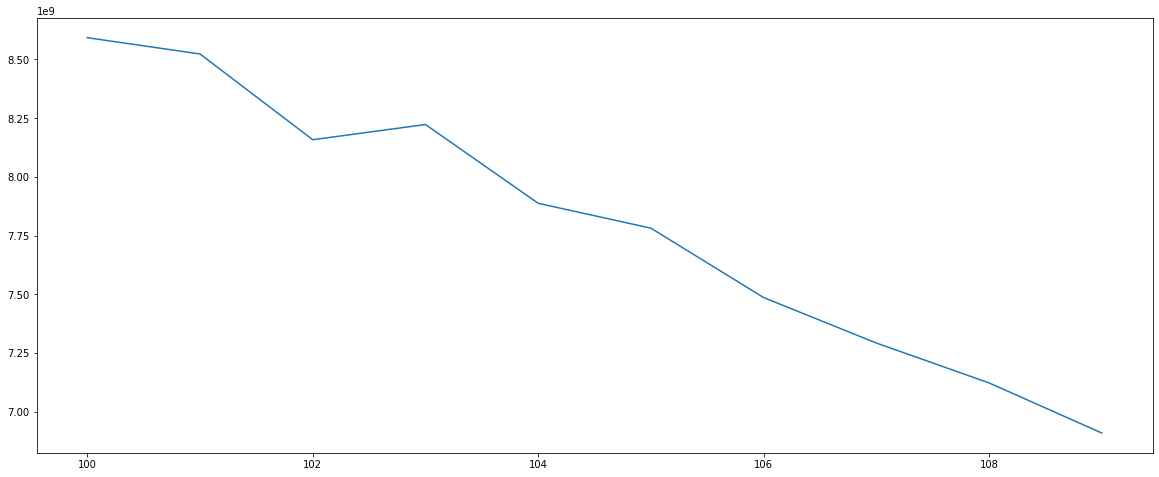

In [27]:
plt.figure(figsize=(20,8))
plt.plot(k, cluster_inertias)  